In [1]:
%matplotlib inline

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import struct
import random
import tensorflow as tf
from IPython.display import Markdown, display
from sklearn import metrics
from sklearn.manifold import TSNE
import os

# Utils 

In [2]:
def make_sure_path_exists(path):
    try:
        os.makedirs(os.path.dirname(path))
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise
        
def plot_images(images, ncols=None):
    ncols = ncols if ncols else len(images)
    images =  np.array(images) 
    nindex, height, width = images.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (images.reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.imshow(result,  cmap='gray')
    plt.axis('off')
    plt.show()
    plt.clf()
    
def error_rate(predictions, labels):
    return (100.0 * np.sum(predictions != labels)/ len(predictions))

def get_incorrect_predictions(predictions, labels):
    return [i for i, (pred, lab) in enumerate(zip(predictions, labels)) if pred != lab]

def get_predictions(prob):
    return np.argmax(prob, 1)

def printmd(string):
    display(Markdown(string))

# Got from https://gist.github.com/akesling/5358964
def read_mnist(dataset, path = "."):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    else:
        raise ValueError( "dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], img[idx])

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_img(i)

# Load data 
It is not a lot, it fits in memory

Split trainset to trainset, validset. Otherwise it would be cheating


In [3]:
validset_size = 10000

trainset = list(read_mnist("training", "data")) 
testset = list(read_mnist("testing", "data"))
validset, trainset = trainset[:validset_size], trainset[validset_size:]
 
print("Loaded {} trainset images".format(len(trainset)))
print("Loaded {} validset images".format(len(validset)))
print("Loaded {} testset images".format(len(testset)))

Loaded 50000 trainset images
Loaded 10000 validset images
Loaded 10000 testset images


Trainset (3, 8, 7, 9, 9, 0, 1, 1, 5, 2, 0, 3, 8, 4, 7)


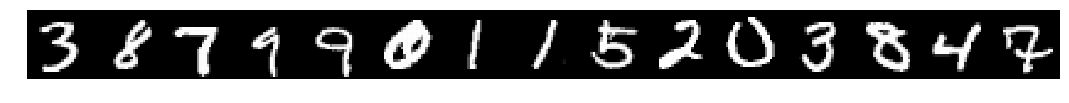

Validset (5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1)


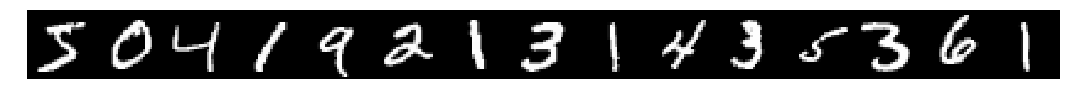

Testset (7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1)


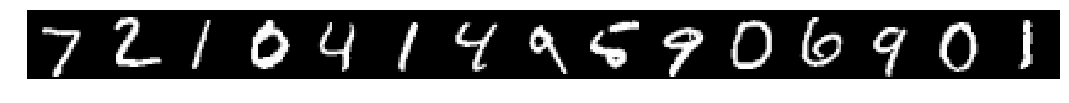

In [4]:
labels, images = zip(*trainset[:15])
print("Trainset", labels)
plot_images(images)

labels, images = zip(*validset[:15])
print("Validset", labels)
plot_images(images)

labels, images = zip(*testset[:15])
print("Testset", labels)
plot_images(images)

# Some stats

In [5]:
label_distribution = Counter([example[0] for example in trainset])
print("Trainset distribution", label_distribution)

label_distribution = Counter([example[0] for example in validset])
print("Validset distribution", label_distribution)

label_distribution = Counter([example[0] for example in testset])
print("Testset distribution", label_distribution)

image_width, image_height = np.array(trainset[0][1]).shape
print("Shape:", image_width, image_height)

label_values = sorted(list(label_distribution.keys()))
print("Label values", label_values)

Trainset distribution Counter({1: 5615, 7: 5195, 3: 5099, 9: 4971, 2: 4967, 0: 4922, 8: 4907, 6: 4904, 4: 4862, 5: 4558})
Validset distribution Counter({1: 1127, 7: 1070, 3: 1032, 6: 1014, 0: 1001, 2: 991, 4: 980, 9: 978, 8: 944, 5: 863})
Testset distribution Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})
Shape: 28 28
Label values [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Almost equally distributed => OK

# Preprocess

In [6]:
num_channels = 1
num_labels = 10
offset = 128

def encode_one_hot(labels):
    return (np.arange(num_labels) == labels[:,None]).astype(np.float32)

def preprocess(dataset, shuffle=False):
    if shuffle:
        random.shuffle(dataset)  # Just in case it was somehow sorted
    labels, images = zip(*dataset)
    labels, images = np.array(labels, dtype="int"), np.array(images, dtype="float32")
    images -= offset  # To be zero centred
    
    images = images.reshape((-1, image_width, image_height, num_channels))  # Add channel dimension

    return labels, images
    
train_labels, train_images = preprocess(trainset, shuffle=True)
valid_labels, valid_images = preprocess(validset)
test_labels, test_images = preprocess(testset)

train_labels_oh = encode_one_hot(train_labels)

## Check dimensions, types etc.
Just to make sure preprocessing is correct

Checking shapes, dtypes, values

train_labels_oh float32 (50000, 10)
train_images float32 (50000, 28, 28, 1) -128.0 127.0


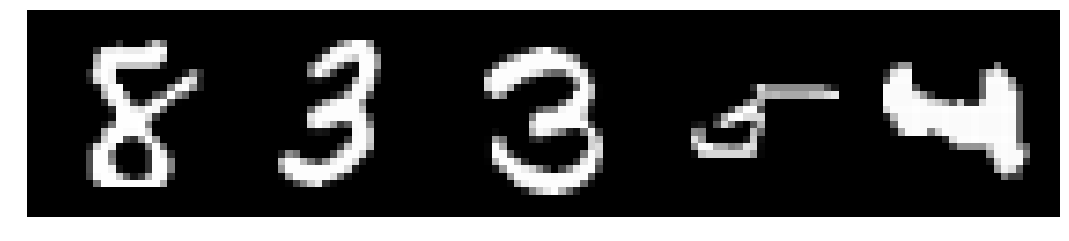

Train labels
[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


In [7]:
print("Checking shapes, dtypes, values\n")
print("train_labels_oh", train_labels_oh.dtype, train_labels_oh.shape)
print("train_images", train_images.dtype, train_images.shape, min(train_images[0, :, :].ravel()), max(train_images[0, :, :].ravel()))
plot_images(train_images[0:5,:,:,0])
print("Train labels")
print(train_labels_oh[0:5, :])

# Training

## Define computational graph
Using simple architecture of convolutional layers connected with relus. Convolutional layers used dropout and 2 fully connected layers with softmax. As a loss function used cross entropy, optimizer Adam.

In [15]:
batch_size = 128
filter_size = 3
nr_filters = 16
num_hidden = 256
nr_cnn_blocks = 6
learning_rate = 0.001

dtype = tf.float32
tf.reset_default_graph() 

# Input data.
tf_train_dataset = tf.placeholder(dtype, shape=(batch_size, image_width, image_height, num_channels))
tf_train_labels = tf.placeholder(dtype, shape=(batch_size, num_labels))
tf_valid_dataset = tf.constant(valid_images, dtype)
tf_test_dataset = tf.constant(test_images, dtype)
training = tf.placeholder(tf.bool, shape=None)

# Variables.
layer1in_weights = tf.Variable(tf.truncated_normal([5, 5, num_channels, nr_filters], stddev=0.1,  dtype=dtype), dtype=dtype)
layer1in_biases = tf.Variable(tf.zeros([nr_filters],  dtype=dtype), dtype=dtype)

layer1fc_weights = tf.Variable(tf.truncated_normal([image_width // 4 * image_height // 4 * nr_filters, num_hidden], stddev=0.1, dtype=dtype), dtype=dtype)
layer1fc_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden], dtype=dtype), dtype=dtype)
layer2fc_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1, dtype=dtype), dtype=dtype)
layer2fc_biases = tf.Variable(tf.constant(1.0, shape=[num_labels], dtype=dtype), dtype=dtype)

# Model.
def model(data, reuse=False):
    data = tf.nn.conv2d(data, layer1in_weights, [1, 2, 2, 1], padding='SAME') + layer1in_biases
    data = tf.nn.relu(data)
    
    for i_block in range(nr_cnn_blocks):
        data = cnn_block(data, i_block, reuse)

    data = tf.nn.max_pool(data, [1, 3, 3, 1],  [1, 2, 2, 1],  padding='SAME')
    hidden = tf.layers.dropout(data, training=training)
    
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])  # Unroll
    embeddings = tf.nn.relu(tf.matmul(reshape, layer1fc_weights) + layer1fc_biases)
    logits = tf.matmul(embeddings, layer2fc_weights) + layer2fc_biases 
    return logits, embeddings


def cnn_block(input_data, i_block, reuse):
    with tf.variable_scope("scope", reuse=reuse):
        layer1_weights = tf.get_variable(
            "layer{}_w".format(i_block), 
            initializer=tf.truncated_normal([filter_size, filter_size, nr_filters, nr_filters], stddev=0.1, dtype=dtype),
            dtype=dtype)
        layer1_biases = tf.get_variable("layer{}_b".format(i_block), initializer=tf.zeros([nr_filters], dtype=dtype), dtype=dtype)

    data = tf.nn.conv2d(input_data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases
    data = tf.nn.relu(data)
#     data = tf.layers.dropout(data, training=training)
    
    return data

# Training computation.
logits, embeddings = model(tf_train_dataset)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

# Optimizer.
global_step = tf.Variable(0, trainable=False)
# learning_rate = tf.train.exponential_decay(learning_rate, global_step, 1000, 0.7)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

# Predictions for the training, validation, and test data.
train_prediction = tf.nn.softmax(logits)
valid_prediction = tf.nn.softmax(model(tf_valid_dataset, reuse=True)[0])
test_logits, test_embeddings = model(tf_test_dataset, reuse=True)
test_prediction = tf.nn.softmax(test_logits)

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

## Run computational graph
Trained using GPU, on CPU training might take a while.

In [16]:
num_steps = 10001
model_path = "models/model.ckpt"

config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth=True
with tf.Session(config=config) as sess:
    tf.global_variables_initializer().run(session=sess)

    min_valid_err = 100
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels_oh.shape[0] - batch_size)
        batch_data = train_images[offset:(offset + batch_size), :, :, :]
        batch_labels_oh = train_labels_oh[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels_oh, training:True}
        _, l, p_train = sess.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        # Printing stats, storing model if good
        if (step % 100 == 0):
            p_valid = valid_prediction.eval(session=sess, feed_dict={training: False})

            train_batch_err =  error_rate(get_predictions(p_train), get_predictions(batch_labels_oh))
            valid_err =  error_rate(get_predictions(p_valid), valid_labels)

            star = ""
            if  valid_err < min_valid_err:
                star = "*"
                min_valid_err = valid_err
                saver.save(sess, model_path)

            print("Step: {:04d}, train_batch_loss: {:.3f}, train_batch_err: {:.2f}%, valid_err: {:.2f}%{}"
                  .format(step, l, train_batch_err, valid_err, star))


    printmd("** Valid err rate {}% **".format(min_valid_err))     


Step: 0000, train_batch_loss: 53.796, train_batch_err: 95.31%, valid_err: 88.47%*
Step: 0100, train_batch_loss: 0.811, train_batch_err: 27.34%, valid_err: 19.51%*
Step: 0200, train_batch_loss: 0.257, train_batch_err: 7.81%, valid_err: 8.03%*
Step: 0300, train_batch_loss: 0.290, train_batch_err: 8.59%, valid_err: 6.25%*
Step: 0400, train_batch_loss: 0.208, train_batch_err: 7.03%, valid_err: 4.41%*
Step: 0500, train_batch_loss: 0.176, train_batch_err: 7.03%, valid_err: 3.70%*
Step: 0600, train_batch_loss: 0.141, train_batch_err: 3.12%, valid_err: 3.63%*
Step: 0700, train_batch_loss: 0.125, train_batch_err: 3.91%, valid_err: 3.16%*
Step: 0800, train_batch_loss: 0.149, train_batch_err: 4.69%, valid_err: 2.87%*
Step: 0900, train_batch_loss: 0.105, train_batch_err: 2.34%, valid_err: 2.75%*
Step: 1000, train_batch_loss: 0.079, train_batch_err: 2.34%, valid_err: 2.41%*
Step: 1100, train_batch_loss: 0.092, train_batch_err: 3.12%, valid_err: 3.25%
Step: 1200, train_batch_loss: 0.149, train_batch

** Valid err rate 0.97% **

# Evaluation

In [22]:
with tf.Session() as sess:
    saver.restore(sess, model_path)
    p_test, embedding_val = sess.run([test_prediction, test_embeddings], feed_dict={training: False})
#     p_test = test_prediction.eval(session=sess, )

test_predictions = get_predictions(p_test)
test_err =  error_rate(test_predictions, test_labels)
printmd("** Test err rate {}% **".format(test_err)) 

INFO:tensorflow:Restoring parameters from models/model.ckpt


** Test err rate 0.85% **

## Draw incorrect predictions
Normally usefull for tweaking training data

Predictions: [8 2 3 4 0 5 7 4 6 3 1 9 5 9 0]
True labels: [5 4 5 9 6 3 2 6 2 5 7 8 3 8 6]


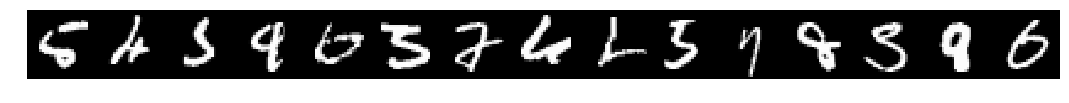

In [23]:
incorrect_predictions = get_incorrect_predictions(test_predictions, test_labels)

nr_incorrect = 15
print("Predictions:", test_predictions[incorrect_predictions[:nr_incorrect]])
print("True labels:", test_labels[incorrect_predictions[:nr_incorrect]])
plot_images([test_images[i, :, :, 0] + offset for i in incorrect_predictions[:nr_incorrect]])

## Print confusion matrix

In [24]:
print("True", " "*20 + "Predicted")
print(metrics.confusion_matrix(test_labels, test_predictions))

True                     Predicted
[[ 979    0    0    0    0    0    0    1    0    0]
 [   0 1133    1    0    0    0    1    0    0    0]
 [   1    0 1026    1    0    0    1    1    2    0]
 [   0    0    0 1006    0    3    0    1    0    0]
 [   0    0    1    0  977    0    1    0    1    2]
 [   1    0    0    8    0  881    1    0    1    0]
 [   5    4    0    0    2    2  943    0    2    0]
 [   0    5    4    0    0    0    0 1016    1    2]
 [   0    0    1    0    0    1    0    0  969    3]
 [   0    0    0    1   12    3    0    5    3  985]]


## Plot embeddings

In [25]:
limit = 1000
embedding2d = TSNE(n_components=2).fit_transform(embedding_val[:limit, :])
test_labels_lim = test_labels[:limit]

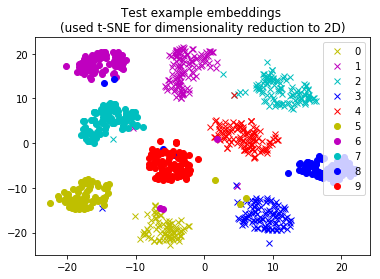

In [27]:
formats = ["xy", "xm", "xc", "xb", "xr", "oy", "om", "oc", "ob", "or"]
for label in label_values:
    plt.plot(embedding2d[test_labels_lim==label, 0], embedding2d[test_labels_lim==label, 1], formats[label])
plt.legend(label_values, loc=1)
plt.title("Test example embeddings \n(used t-SNE for dimensionality reduction to 2D)")